# Various TE and T_ME models comparison

In this notebook, we first show the results of running a TE_coupled_AE for all patchseq cells used in the inh and exc patchseq papers. More specifically, we will run T_only and E_only autoencoders and then TE_coupled autoencoders, then we use the latent representations of each of these models to classify T_types. We expect to see that coupling E to T, will improve the T_type classification accuracy of E arm when compared to the baseline E_only autoencoder. We will show that, this result is obtained only if we implement augmentation for the T and E decoders in the TE_coupled_AE model. 

After that, we present the T_ME coupled autoencoder. The hypothesis in this 3 modality coupled AE is that, M data will enrich E data and if we couple ME autoencoder to T autoencoder, then latent representation of ME arm is better than baseline ME_alone_AE or TE_coupled_AE or T_M_E autoencoder. 

In [1]:
import os
import umap 
import umap.plot
import umap.aligned_umap
import matplotlib.pyplot as plt

import torch
from cplAE_MET.models.pytorch_models import Model_T_ME
from cplAE_MET.models.torch_helpers import astensor, tonumpy
from functools import partial

import numpy as np
import pandas as pd
import cplAE_MET.utils.utils as ut
import cplAE_MET.utils.umap_helpers as ut_umap
import cplAE_MET.utils.analysis_helpers as ana
from cplAE_MET.utils.dataset import  load_MET_dataset, MET_data_summary

# This is used to be able to run the notebook both remote and locally
Allen_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/"
remote_dir = "/Users/fahimehb/Documents/git-workspace/cplAE_MET/data/"

parent_dir = Allen_dir

/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/miniconda3/envs/cplmet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MET_data = load_MET_dataset(parent_dir + "proc/MET_data_16Feb22.mat")
MET_data_summary(MET_data)

T shape (5468, 1252)
E shape (5468, 134)
M shape (5468, 120, 4, 4)
sd shape (5468,)

Paired samples, allowing for nans in some features
5322 cells paired in T and E
1454 cells paired in T and M
1399 cells paired in E and M

Paired samples, without nans in any feature (strict)
5322 cells paired in T and E
1454 cells paired in T and M
1399 cells paired in E and M


In [3]:
MET_data = load_MET_dataset(parent_dir + "proc/MET_data_30Mar22.mat")
MET_data_summary(MET_data)

T shape (6570, 1252)
E shape (6570, 132)
M shape (6570, 120, 4, 4)
sd shape (6570,)

Paired samples, allowing for nans in some features
5854 cells paired in T and E
1515 cells paired in T and M
1413 cells paired in E and M

Paired samples, without nans in any feature (strict)
5854 cells paired in T and E
1515 cells paired in T and M
1413 cells paired in E and M


# TE_autoencoder

We ran multiple TE_coupled_AE with varied directional coupling strength between T and E arms. First, this was done in the absense of the augment_decoders. Also the baseline T_only_AE and E_only_AE were implemented. For each of the runs, we used QDA classifier to compute the accuracy of T_type classification from the latent representations. 

In [4]:
TE_runs_path = parent_dir + "/results/triple_mode_version_0.0/"

TE_run_folders = [
    # models without augment_decoder implemented
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_10.0_aE_10.0_lmd_TE_1.0_lmd_tune_TE_0.5",
    "min_var_loss_TE_aT_2.0_aE_2.0_lmd_TE_1.0_lmd_tune_TE_0.5",
    "min_var_loss_TE_aT_5.0_aE_5.0_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_0.5_aE_0.5_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_100.0_aE_100.0_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_50.0_aE_50.0_lmd_TE_1.0_lmd_tune_TE_0.5", 
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_0.0_lmd_tune_TE_0.0",
    # models with augment_decoder implemented
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_0.75_aug_dec_1.0", 
    "min_var_loss_TE_aT_2.0_aE_2.0_lmd_TE_1.0_lmd_tune_TE_0.5_aug_dec_1.0",
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_1.0_aug_dec_1.0",
    "min_var_loss_TE_aT_0.5_aE_0.5_lmd_TE_1.0_lmd_tune_TE_0.5_aug_dec_1.0",
    "min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_0.5_aug_dec_1.0"]

In [5]:
alldf = pd.DataFrame()
output = {}
for folder in TE_run_folders:
    files_path = TE_runs_path+folder + "/"
    files = os.listdir(files_path)
    out, df = ana.get_TE_pkl_keys(files_path, files)
    output.update(out)
    alldf = pd.concat([df, alldf],  ignore_index=True)
    

In [6]:
# All the TE runs with and without aug_decs
alldf

,alphaT,alphaE,lambda_TE,lambda_tune_TE,aug_dec,latent_dim,fold,classification_acc_zt,classification_acc_ze,recon_loss_xt,recon_loss_xe
0,1.0,1.0,1.0,0.5,1.0,5,5,73.491773,43.789474,1.932613,0.065373
1,1.0,1.0,1.0,0.5,1.0,5,1,72.029250,41.894737,1.933841,0.074694
2,1.0,1.0,1.0,0.5,1.0,5,3,72.394881,42.105263,1.893291,0.060597
3,1.0,1.0,1.0,0.5,1.0,5,2,71.297989,43.789474,1.946871,0.066104
4,1.0,1.0,1.0,0.5,1.0,5,8,71.663620,42.526316,1.907636,0.063606
...,...,...,...,...,...,...,...,...,...,...,...
123,1.0,1.0,1.0,0.5,0.0,5,7,72.760512,38.105263,1.913934,0.055723
124,1.0,1.0,1.0,0.5,0.0,5,0,74.040219,31.157895,1.866193,0.056368
125,1.0,1.0,1.0,0.5,0.0,5,2,71.846435,29.263158,1.972910,0.043704
126,1.0,1.0,1.0,0.5,0.0,5,4,75.319927,30.947368,1.872821,0.060134


Below, the first row is the baseline and shows the classification acc for the T_only_AE and E_only_AE which are 76.6% and 35.22% correspondingly. The rest of the table shows the effect of changing alphaT and alphaE in the TE_coupled_AE model. As it is clear, only when we increase these values a lot, the model accuracy gets better than the baseline for both arms. Increasing the alphaT and alphaE while keeping lambda_TE constant, means encouraging the model to mainly focus on the T and E autoencoders and not caring much about the coupling. As this is contrary to what we want (to enrich the model by coupling), we decided to implement more augmentation to the model to see if we can improve the results. 

In [7]:
# grouping tests without the aug_decs
alldf[alldf['aug_dec']!=1].groupby(["aug_dec", "lambda_TE", "alphaT", "alphaE"]).mean().drop(columns=["fold"])

lambda_tune_TE  latent_dim  \
aug_dec lambda_TE alphaT alphaE                               
0.0     0.0       1.0    1.0                0.0         5.0   
        1.0       0.5    0.5                0.5         5.0   
                  1.0    1.0                0.5         5.0   
                  2.0    2.0                0.5         5.0   
                  5.0    5.0                0.5         5.0   
                  10.0   10.0               0.5         5.0   
                  50.0   50.0               0.5         5.0   
                  100.0  100.0              0.5         5.0   

                                 classification_acc_zt  classification_acc_ze  \
aug_dec lambda_TE alphaT alphaE                                                 
0.0     0.0       1.0    1.0                 76.636197              35.221053   
        1.0       0.5    0.5                 73.308958              32.888889   
                  1.0    1.0                 73.455210              32.884211   
                  2.0    2.0                 74.186472              34.126316   
                  5.0    5.0                 74.954296              35.136842   
                  10.0   10.0                75.929311              35.415205   
                  50.0   50.0                76.819013              36.421053   
                  100.0  100.0               76.672761              36.842105   

                                 recon_loss_xt  recon_loss_xe  
aug_dec lambda_TE alphaT alphaE                                
0.0     0.0       1.0    1.0          1.925121       0.032674  
        1.0       0.5    0.5          1.867399       0.070778  
                  1.0    1.0          1.884191       0.063739  
                  2.0    2.0          1.913598       0.055476  
                  5.0    5.0          1.943060       0.049854  
                  10.0   10.0         1.990347       0.052797  
                  50.0   50.0         2.039525       0.040777  
                  100.0  100.0        2.040239       0.040637

Below, we present the results of the model in the presence of the augment_decoders. As it is suggested by the table, we could improve the results of the classification acc by implementing augmentation. especially, the E_arm classification acc is improved. Furthermore, we can improve the results by changing the alphaT and alphaE values as it is seen in the follwoing table.

In [8]:
# grouping tests with the aug_decs and equal strength coupling between T and E
alldf[(alldf['aug_dec']==1) & (alldf['lambda_tune_TE']==0.5)].groupby(["aug_dec","lambda_TE", "alphaT", "alphaE"]).mean().drop(columns=["fold"])

lambda_tune_TE  latent_dim  \
aug_dec lambda_TE alphaT alphaE                               
1.0     1.0       0.5    0.5                0.5         5.0   
                  1.0    1.0                0.5         5.0   
                  2.0    2.0                0.5         5.0   

                                 classification_acc_zt  classification_acc_ze  \
aug_dec lambda_TE alphaT alphaE                                                 
1.0     1.0       0.5    0.5                 71.297989              40.084211   
                  1.0    1.0                 72.138940              43.115789   
                  2.0    2.0                 73.455210              46.210526   

                                 recon_loss_xt  recon_loss_xe  
aug_dec lambda_TE alphaT alphaE                                
1.0     1.0       0.5    0.5          1.917425       0.070653  
                  1.0    1.0          1.920738       0.065997  
                  2.0    2.0          1.928929       0.059113

On a side note, as table below is suggesting, when we move the TE_coupled_AE towards one-directional coupled_TE  for which T is affecting E representation but E is not affecting T the T-type classification acc is much higher. 

In [9]:
# grouping tests with aug_decs and varried lambda_tune_TE
alldf[(alldf['alphaT']==1.0) & alldf['aug_dec']==1.0].groupby(["aug_dec","lambda_tune_TE"]).mean().drop(columns=["fold"])

alphaT  alphaE  lambda_TE  latent_dim  \
aug_dec lambda_tune_TE                                          
1.0     0.50               1.0     1.0        1.0         5.0   
        0.75               1.0     1.0        1.0         5.0   
        1.00               1.0     1.0        1.0         5.0   

                        classification_acc_zt  classification_acc_ze  \
aug_dec lambda_tune_TE                                                 
1.0     0.50                        72.138940              43.115789   
        0.75                        73.638026              46.526316   
        1.00                        76.855576              60.652632   

                        recon_loss_xt  recon_loss_xe  
aug_dec lambda_tune_TE                                
1.0     0.50                 1.920738       0.065997  
        0.75                 1.906377       0.077091  
        1.00                 1.887109       0.105252

Let's look at one of the coupled TE model with bidirectional coupling, alphaT=alphaE=2 and aug_decs=True. 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


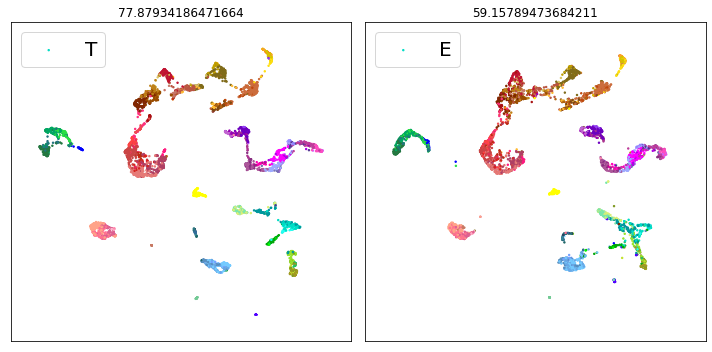

In [10]:
results_path = parent_dir + "/results/triple_mode_version_0.0/min_var_loss_TE_aT_1.0_aE_1.0_lmd_TE_1.0_lmd_tune_TE_1.0_aug_dec_1.0/"
exit_summary = "exit_summary_min_var_loss_TE_aT_1-0_aE_1-0_lambda_TE_1-0_lambda_tune_TE_1-0_Enoise_0-05_aug_dec_1_ld_5_ne_20000_ri_0_fold_1.pkl"

TE = ut.loadpkl(results_path + exit_summary)
valid_E = TE['valid_E']
valid_T = TE['valid_T']
valid_TE = np.where(valid_E & valid_T, True, False)
valid_TE_E = valid_TE[valid_E]
valid_TE_T = valid_TE[valid_T]

# relation is between consecutive pair of data 
relation = dict(zip(np.where(valid_TE_T)[0] ,np.where(valid_TE_E)[0]))
embs = [TE['zt'], TE['ze']]

aligned_mapper = umap.AlignedUMAP().fit(embs, relations=[relation])

def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    current_target = [TE['cluster_color'][TE["valid_T"]], TE['cluster_color'][TE["valid_E"]]]
    current_label = ["T", "E"]
    current_title = [TE['classification_acc_zt'], TE['classification_acc_ze']]
    ax.scatter(*aligned_mapper.embeddings_[i].T, s=2, c=current_target[i], cmap="Spectral", label=current_label[i])
    ax.set_title(current_title[i])
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
    ax.legend(prop={'size': 20})
plt.tight_layout()


# Various T_ME coupled AE

In the following, we add the M data to T and E and try to build a model in which M data is improving our previous TE model. We had many questions to be answered:
 - Does T-ME_coupled_AE performs better than TE_coupled_AE in classification of T types? the hypothesis is that, M data should enrich E data and then coupling ME with T should gives us a better model than TE.
 - Does T-M-E_coupled_AE performs worse than T_ME_coupled_AE? the hypothesis is that, E and M data are not very high resolution, therefore combining M and E should gives us a better model.
 - Does T-ME_coupled_AE perfroms better than ME and T alone?
 - Does adding M and E autoencoder improve the results in ME arm?

In [11]:
T_ME_runs_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/triple_mode_version_0.0/"
T_ME_runs_folders = [
    # Without aug_dec
    "T_ME_aT_0.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_0.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.0",
    "T_ME_aT_0.5_aE_0.5_aM_0.5_aME_0.5_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5",
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_0.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_0.0", 
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_0.5",
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_0.75",
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_0.9",
    "T_ME_aT_1.0_aE_0.0_aM_0.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_0.0_lmd_ME_E_0.0_lmd_tune_ME_T_1.0",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.75",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.9",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_1.0",
    "T_ME_aT_2.0_aE_2.0_aM_2.0_aME_2.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5",
    "T_ME_aT_5.0_aE_5.0_aM_5.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5",
    # With aug_dec
    "T_ME_aT_0.5_aE_0.5_aM_0.5_aME_0.5_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5_aug_dec_1",
    "T_ME_aT_1.0_aE_1.0_aM_1.0_aME_1.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5_aug_dec_1",
    "T_ME_aT_2.0_aE_2.0_aM_2.0_aME_2.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5_aug_dec_1",
    "T_ME_aT_5.0_aE_5.0_aM_5.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.5_aug_dec_1",
     # Added more cells to the model, some have only M
    "more_cells_T_ME_aT_5.0_aE_5.0_aM_5.0_asd_1.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.75_aug_dec_1"
    ]

In [12]:
# This might take several minutes
alldf = pd.DataFrame()
for folder in T_ME_runs_folders:
    files_path = T_ME_runs_path + folder + "/"
    files = os.listdir(files_path)
    out, df = ana.get_T_ME_version_0_0_pkl_keys(files_path, files)
    alldf = pd.concat([df, alldf],  ignore_index=True)

In [13]:
alldf['aug_dec']= alldf['aug_dec'].fillna(0)

In [14]:
alldf

,aT,aE,aM,asd,aME,lambda_ME_T,lambda_ME_M,lambda_ME_E,lambda_tune_ME_T,latent_dim,aug_dec,fold,classification_acc_zt,classification_acc_ze,classification_acc_zm,classification_acc_zme
0,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,8,74.307692,35.019455,40.410959,56.666667
1,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,9,78.769231,35.408560,28.082192,72.500000
2,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,4,75.230769,36.770428,38.356164,64.166667
3,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,8,66.923077,33.852140,30.136986,53.333333
4,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,0.75,5,1.0,6,76.615385,33.073930,34.931507,64.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.00,5,0.0,3,19.195612,26.105263,35.507246,43.333333
237,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.00,5,0.0,9,18.098720,28.421053,26.086957,49.166667
238,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.00,5,0.0,2,18.098720,28.421053,34.782609,50.000000
239,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.00,5,0.0,4,15.722121,29.263158,37.681159,50.000000


First of all, we would like to know what is the classification acc for the ME_only_AE and T_only_AE. for T data the accuracy is 78% and for ME together it is 47%. Note that E_only_AE had an accuracy of almost 35%. So this is proving that adding M data to E, has already boost the model. 

In [15]:
# baseline ME and T UNcoupled autoencoders 
alldf[(alldf['lambda_ME_T']==0.0) & (alldf['aT']==1.0)][["classification_acc_zt", "classification_acc_zme", "classification_acc_ze", "classification_acc_zm"]].mean()

classification_acc_zt     78.043876
classification_acc_zme    47.333333
classification_acc_ze     24.252632
classification_acc_zm     31.521739
dtype: float64

One other thing that I was curious to try was an ME_AE in which we have M_AE and E_AE coupled to it one directionally. Meaning that E and M can't affect zme and it is only zme which is affecting ze and zm. Our results suggest that this model, improved with respect to the previous model in which we did not have a coupling between ME and E as well as between ME and M. 

In [16]:
alldf[(alldf['lambda_ME_T']==0.0) & (alldf['aT']!=1.0)][["classification_acc_zt", "classification_acc_zme", "classification_acc_ze", "classification_acc_zm"]].mean()

classification_acc_zt     17.123705
classification_acc_zme    48.333333
classification_acc_ze     28.257310
classification_acc_zm     33.655395
dtype: float64

Now, lets couple ME and T. there is no E or M autoencoders and no connection between ME and E or ME and M representations. The only thing which can be kind of a "coupling" is that ME are shares decoders with M and E arms. This means, we are expecting to see a better M and E representations just because the decoders are having information from ME arm. but when we look at the representations, the orientations of M and E are not going to be aligned as ME and T.

Below, we present the results of the ME_T coupling, also we have played with the directionality of the coupling. 

As it is clear from the table, the results in all the arms are better than the uncoupled version presented above.

In [17]:
alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==0.0)].groupby(['lambda_tune_ME_T']).mean().drop(columns=['fold'])

,aT,aE,aM,asd,aME,lambda_ME_T,lambda_ME_M,lambda_ME_E,latent_dim,aug_dec,classification_acc_zt,classification_acc_ze,classification_acc_zm,classification_acc_zme
lambda_tune_ME_T,,,,,,,,,,,,,,
0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,74.460695,29.957895,33.623188,52.666667
0.75,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,75.722121,31.726316,33.188406,57.000000
0.90,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,77.074954,32.610526,34.782609,63.583333
1.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,77.202925,32.842105,28.768116,71.166667


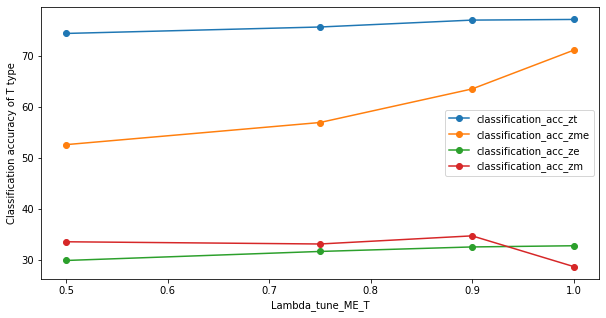

In [18]:
subdf = alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==0.0)].groupby(['lambda_tune_ME_T']).mean().drop(columns=['fold']).reset_index()

fig = plt.figure(figsize=(10,5))

current_label = [
    "classification_acc_zt", "classification_acc_zme", 
    "classification_acc_ze", "classification_acc_zm"]

for i, var in enumerate([
    subdf['classification_acc_zt'], subdf['classification_acc_zme'], 
    subdf['classification_acc_ze'], subdf['classification_acc_zm']]):

    plt.plot(subdf['lambda_tune_ME_T'], var, "o-", label=current_label[i])

plt.xlabel("Lambda_tune_ME_T")
plt.ylabel("Classification accuracy of T type")

plt.legend()

As we are interested, in bidirectional coupling between ME and T autoencoders, we set the lambda_tune_ME_T to 0.5 and changed alphaE, alphaT, alphaM and alphaME. Moreover, we implemented the augmentation for decoders and table below summarized the results. 

In [19]:
alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==1.0) & (alldf['lambda_tune_ME_T']==0.5) & (alldf['asd']==alldf['aM'])].groupby(["aug_dec", "aT"]).mean().drop(columns=["fold"])

aE   aM  asd  aME  lambda_ME_T  lambda_ME_M  lambda_ME_E  \
aug_dec aT                                                               
0.0     0.5  0.5  0.5  0.5  0.5          1.0          1.0          1.0   
        1.0  1.0  1.0  1.0  1.0          1.0          1.0          1.0   
        2.0  2.0  2.0  2.0  2.0          1.0          1.0          1.0   
        5.0  5.0  5.0  5.0  5.0          1.0          1.0          1.0   
1.0     0.5  0.5  0.5  0.5  0.5          1.0          1.0          1.0   
        1.0  1.0  1.0  1.0  1.0          1.0          1.0          1.0   
        2.0  2.0  2.0  2.0  2.0          1.0          1.0          1.0   
        5.0  5.0  5.0  5.0  5.0          1.0          1.0          1.0   

             lambda_tune_ME_T  latent_dim  classification_acc_zt  \
aug_dec aT                                                         
0.0     0.5               0.5         5.0              73.528336   
        1.0               0.5         5.0              74.748629   
        2.0               0.5         5.0              75.612431   
        5.0               0.5         5.0              76.764168   
1.0     0.5               0.5         5.0              70.950640   
        1.0               0.5         5.0              73.016453   
        2.0               0.5         5.0              74.789762   
        5.0               0.5         5.0              74.606947   

             classification_acc_ze  classification_acc_zm  \
aug_dec aT                                                  
0.0     0.5              25.515789              33.985507   
        1.0              24.763158              31.974638   
        2.0              28.168421              31.231884   
        5.0              29.873684              32.898551   
1.0     0.5              26.905263              33.188406   
        1.0              30.357895              34.057971   
        2.0              32.589474              33.115942   
        5.0              34.652632              35.144928   

             classification_acc_zme  
aug_dec aT                           
0.0     0.5               51.750000  
        1.0               53.020833  
        2.0               54.583333  
        5.0               53.666667  
1.0     0.5               62.083333  
        1.0               63.916667  
        2.0               65.583333  
        5.0               66.500000

In [20]:
alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==1.0) & (alldf['asd']!=alldf['aM']) & (alldf['latent_dim']==5)].groupby(['aug_dec', 'lambda_tune_ME_T']).mean().drop(columns=['fold'])

,,aT,aE,aM,asd,aME,lambda_ME_T,lambda_ME_M,lambda_ME_E,latent_dim,classification_acc_zt,classification_acc_ze,classification_acc_zm,classification_acc_zme
aug_dec,lambda_tune_ME_T,,,,,,,,,,,,,
1.0,0.75,5.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,5.0,74.495069,34.306096,31.954689,63.472222


Text(0.5, 0, 'AlphaE / AlphaT / AlphaM / AlphaME')

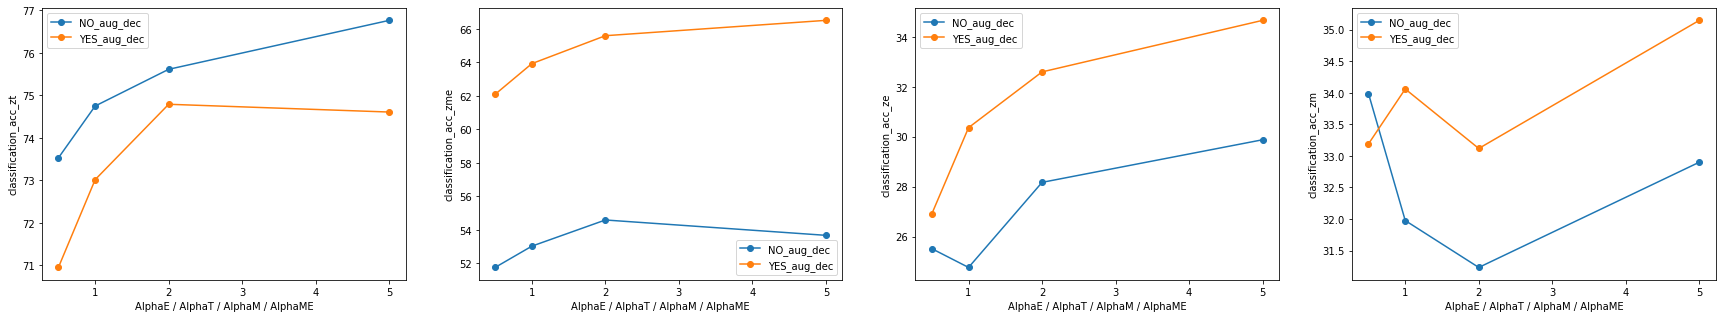

In [21]:
subdf = alldf[(alldf['lambda_ME_T']==1.0) & (alldf['lambda_ME_M']==1.0) & (alldf['lambda_tune_ME_T']==0.5)].groupby(["aug_dec", "aT"]).mean().drop(columns=["fold"]).reset_index()
subsubdf1 = subdf[subdf["aug_dec"]==0.0]
subsubdf2 = subdf[subdf["aug_dec"]==1.0]

fig, axs = plt.subplots(1,4, figsize=(30, 5))
for i, ax in enumerate(axs.flatten()):
    for sdf, marker, aug in zip([subsubdf1, subsubdf2], ["o-", "x-"], ["NO_aug_dec", "YES_aug_dec"]):
        var = [sdf['classification_acc_zt'], sdf['classification_acc_zme'], sdf['classification_acc_ze'], sdf['classification_acc_zm']]
        current_label = ["classification_acc_zt", "classification_acc_zme", "classification_acc_ze", "classification_acc_zm"]
        ax.plot(sdf['aT'], var[i], "o-", label=aug)
        ax.legend()
        ax.set_xlabel("AlphaE / AlphaT / AlphaM / AlphaME")
        ax.set_ylabel(current_label[i])

plt.xlabel("AlphaE / AlphaT / AlphaM / AlphaME")

Classification accuracy of zt drops by a bit when augmenting decoders (top figure left). Classification acc os zme, ze and zm has improved. more importantly this value improved a lot for zme. Also increasing alphaE, T, M and ME increased the classification accuary of all the above tests.

In [22]:
def plot_aligned_umap(model_output):
    
    embs = ut_umap.get_T_ME_model_emb_list(model_output)

    relations = ut_umap.get_T_ME_model_umap_relation_list(model_output)

    color_list = ut_umap.get_T_ME_model_umap_colors_list(model_output)

    title_list = [model_output['classification_acc_zt'],
     model_output['classification_acc_ze'], 
     model_output['classification_acc_zme'],
      model_output['classification_acc_zm']]

    label_list = ["T", "E", "ME", "M"]

    ut_umap.plot_aligned_umap_T_ME(embs, relations, color_list, title_list, label_list)

    return

def plot_xsd_recon_for_Mval_cells(model_output):
    """
    Args:
        model_output: output of the T_ME model which has masks and recons 
    """
    # index of M cells from the total cells
    M_cells_ind_tot = np.where(model_output['M_tot'])[0]
    # index of validation cells from the total cells
    val_cells_ind_tot = model_output['val']
    # index of M validation cells from the total cells
    M_val_cells_ind_tot = np.array([i for i in M_cells_ind_tot if i in val_cells_ind_tot])
    # index of M validation cells from the M cells
    M_val_cells_ind_M = np.searchsorted(M_cells_ind_tot, M_val_cells_ind_tot)

    plt.figure(figsize=(20,5))
    plt.scatter(range(len(model_output['Xsd'][M_val_cells_ind_tot])), model_output['Xsd'][M_val_cells_ind_tot], label="Xsd")
    plt.scatter(range(len(model_output['Xrsd'][M_val_cells_ind_M])), model_output['Xrsd'][M_val_cells_ind_M], label="Xrsd")
    plt.legend()
    plt.xlabel("validation cells")
    plt.ylabel("soma depth")
    plt.title("Reconstructing soma depth")
    plt.show()


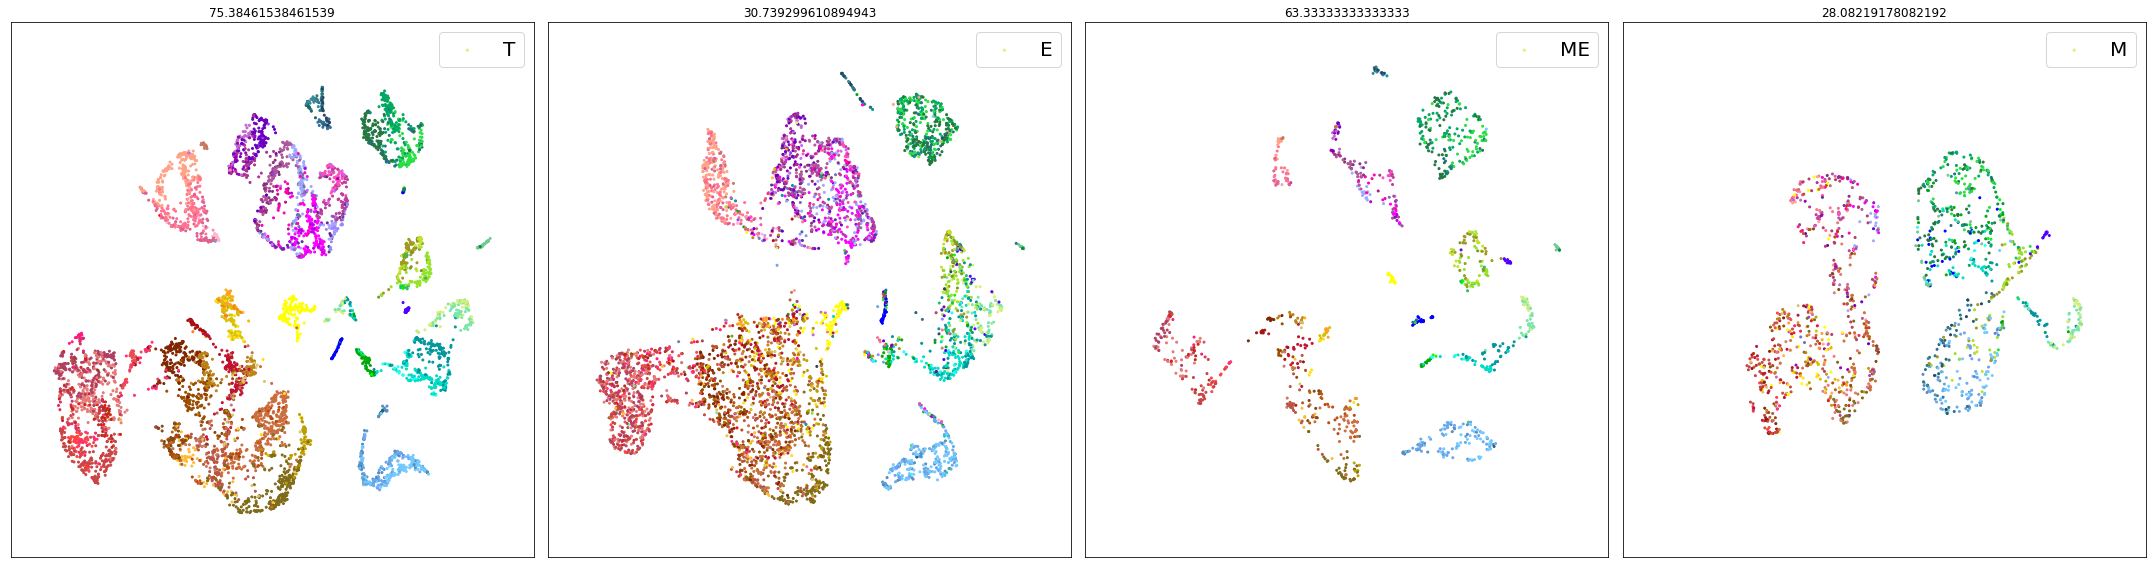

In [23]:
results_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/triple_mode_version_0.0/more_cells_T_ME_aT_5.0_aE_5.0_aM_5.0_asd_1.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.75_aug_dec_1/"
exit_summary = "exit_summary_more_cells_T_ME_aT_5-0_aM_5-0_asd_1-0_aE_5-0_aME_5-0_lambda_ME_T_1-0_lambda_tune_ME_T_0-75_lambda_ME_M_1-0_lambda_ME_E_1-0_aug_dec_1_Enoise_0-05_Mnoise_0-0_scale_0-3_ld_5_ne_50000_ri_0_fold_2.pkl"
T_ME = ut.loadpkl(results_path + exit_summary)

plot_aligned_umap(T_ME)

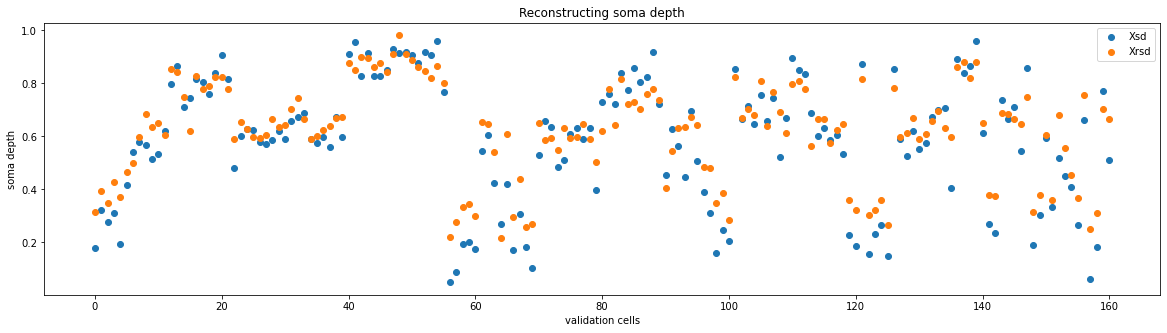

In [24]:
plot_xsd_recon_for_Mval_cells(T_ME)

### Fixing the validation set during the model training and classification

So far for all the runs, I have used a different set of validation cells during the model run and classification task. In the following, this has been fixed and the validation set for each fold was the same in the model tarning and in the classification task.

In [25]:
T_ME_runs_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/"
T_ME_runs_folders = [
    # Without aug_dec
    "triple_mode_version_0.0/corrected_val_cells_T_ME_aT_5.0_aE_5.0_aM_5.0_asd_5.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.75_aug_dec_1",
    ]
# This might take several minutes
alldf = pd.DataFrame()
for folder in T_ME_runs_folders:
    files_path = T_ME_runs_path + folder + "/"
    files = os.listdir(files_path)
    out, df = ana.get_T_ME_version_0_0_pkl_keys(files_path, files)
    alldf = pd.concat([df, alldf],  ignore_index=True)

In [26]:
alldf

,aT,aE,aM,asd,aME,lambda_ME_T,lambda_ME_M,lambda_ME_E,lambda_tune_ME_T,latent_dim,aug_dec,fold,classification_acc_zt,classification_acc_ze,classification_acc_zm,classification_acc_zme
0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,0,72.419106,34.669339,25.675676,46.428571
1,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,6,74.961598,30.550285,38.888889,49.122807
2,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,5,73.732719,29.356061,22.368421,48.837209
3,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,2,73.805855,33.858268,30.000000,53.225806
4,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,7,73.189522,29.921260,20.300752,45.714286
5,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,8,73.384615,33.583490,19.736842,46.400000
6,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,1,71.340524,28.256513,34.057971,47.899160
7,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,3,71.648690,34.808853,28.662420,46.456693
8,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,9,69.799692,26.771654,22.602740,56.302521
9,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,5,1.0,4,76.769231,34.535104,34.437086,55.200000


In [27]:
print("classification acc zt", alldf['classification_acc_zt'].mean())
print("classification acc ze", alldf['classification_acc_ze'].mean())
print("classification acc zme", alldf['classification_acc_zme'].mean())
print("classification acc zm", alldf['classification_acc_zm'].mean())

classification acc zt 73.10515524206066
classification acc ze 31.631082520589995
classification acc zme 49.558705349999414
classification acc zm 27.67307968175595


Lets look at the latent reps of one of the best folds:

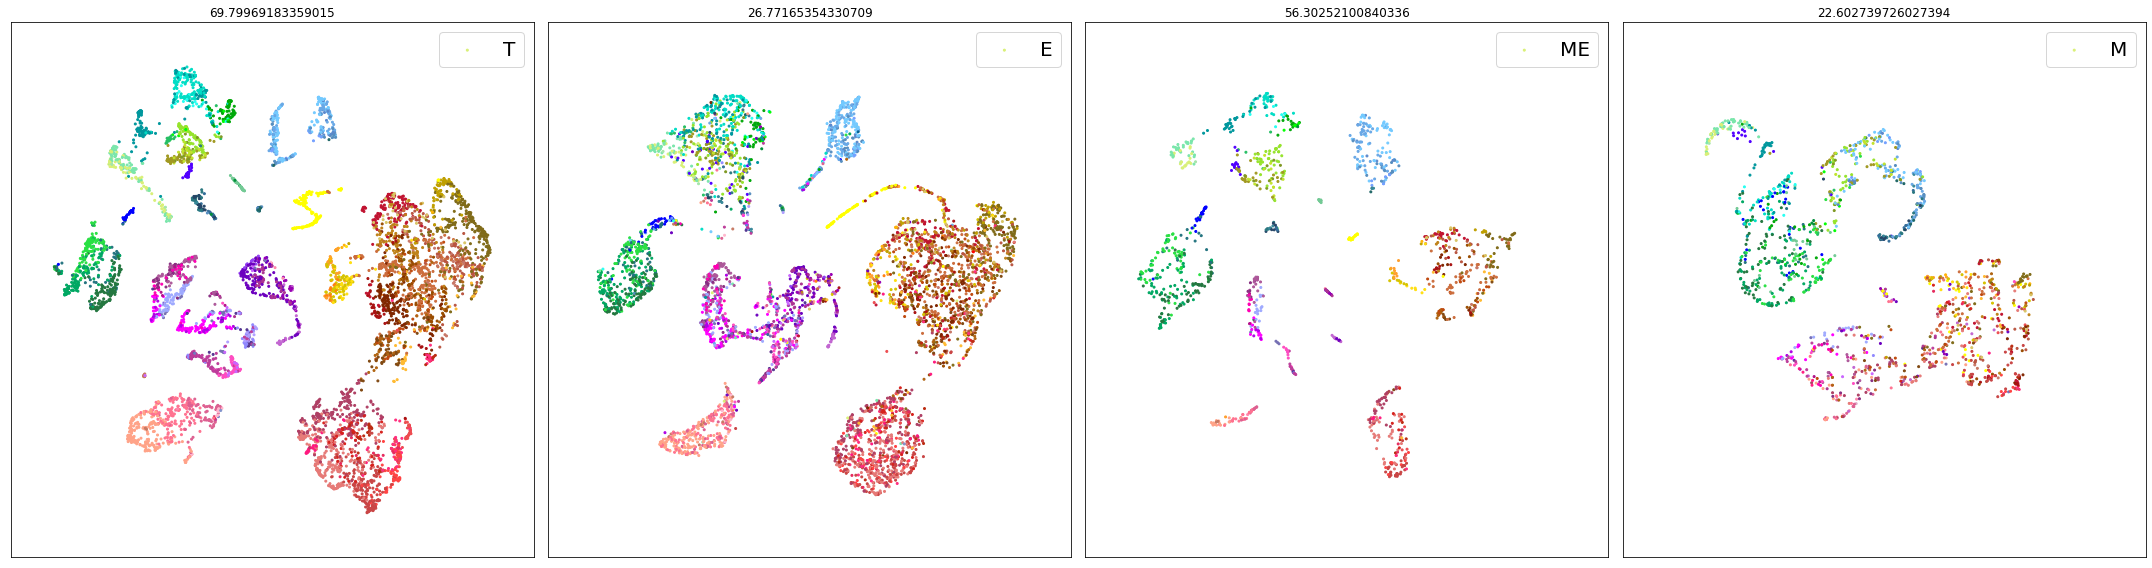

In [28]:
results_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/triple_mode_version_0.0/corrected_val_cells_T_ME_aT_5.0_aE_5.0_aM_5.0_asd_5.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.75_aug_dec_1/"
exit_summary = "exit_summary_corrected_val_cells_T_ME_aT_5-0_aM_5-0_asd_5-0_aE_5-0_aME_5-0_lambda_ME_T_1-0_lambda_tune_ME_T_0-75_lambda_ME_M_1-0_lambda_ME_E_1-0_aug_dec_1_Enoise_0-05_Mnoise_0-0_scale_0-3_ld_5_ne_50000_ri_0_fold_9.pkl"
T_ME = ut.loadpkl(results_path + exit_summary)

plot_aligned_umap(T_ME)

### Model version 1.0

reminder of T_ME version 0.0 (all the runs above are done with this model):

  T <--> ME

  ME --> M
  
  ME --> E

T_ ME version 1.0:

T <--> ME

T --> M

T --> E

In the following, we present the results of the version 1.0 model.

In [29]:
T_ME_runs_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/"
T_ME_runs_folders = [
    # Without aug_dec
    "triple_mode_version_1.0/corrected_val_cells_T_ME_aT_5.0_aE_5.0_aM_5.0_asd_5.0_aME_5.0_lmd_ME_T_1.0_lmd_E_T_1.0_lmd_M_T_1.0_lmd_tune_ME_T_0.75_aug_dec_1/",
    ]
# This might take several minutes
alldf = pd.DataFrame()
for folder in T_ME_runs_folders:
    files_path = T_ME_runs_path + folder + "/"
    files = os.listdir(files_path)
    out, df = ana.get_T_ME_version_1_0_pkl_keys(files_path, files)
    alldf = pd.concat([df, alldf],  ignore_index=True)

We ran this model with three different latent dim in order to see if results going to improve with a nigher number of latent_dim

In [30]:
alldf.groupby('latent_dim').mean().drop(columns=["fold"])

,aT,aE,aM,asd,aME,lambda_ME_T,lambda_E_T,lambda_M_T,lambda_tune_ME_T,aug_dec,classification_acc_zt,classification_acc_ze,classification_acc_zm,classification_acc_zme
latent_dim,,,,,,,,,,,,,,
5,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,1.0,72.352184,35.937636,27.165408,50.802523
10,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,1.0,73.042977,33.545524,26.253411,43.438812
20,5.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.75,1.0,67.036103,33.690890,22.130766,35.358811


How does the reconstruction of arbor density images look like:

246


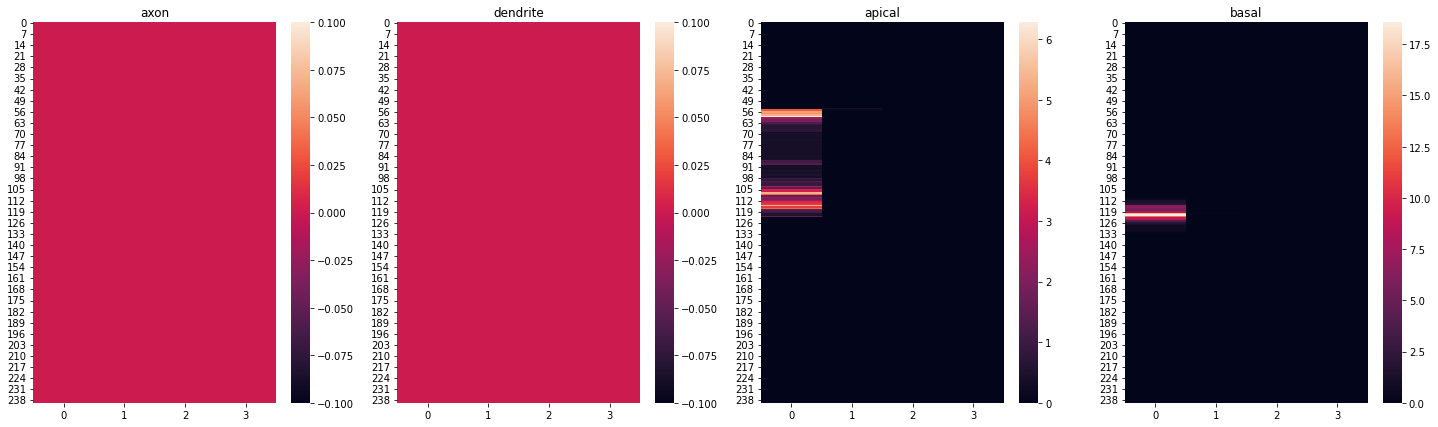

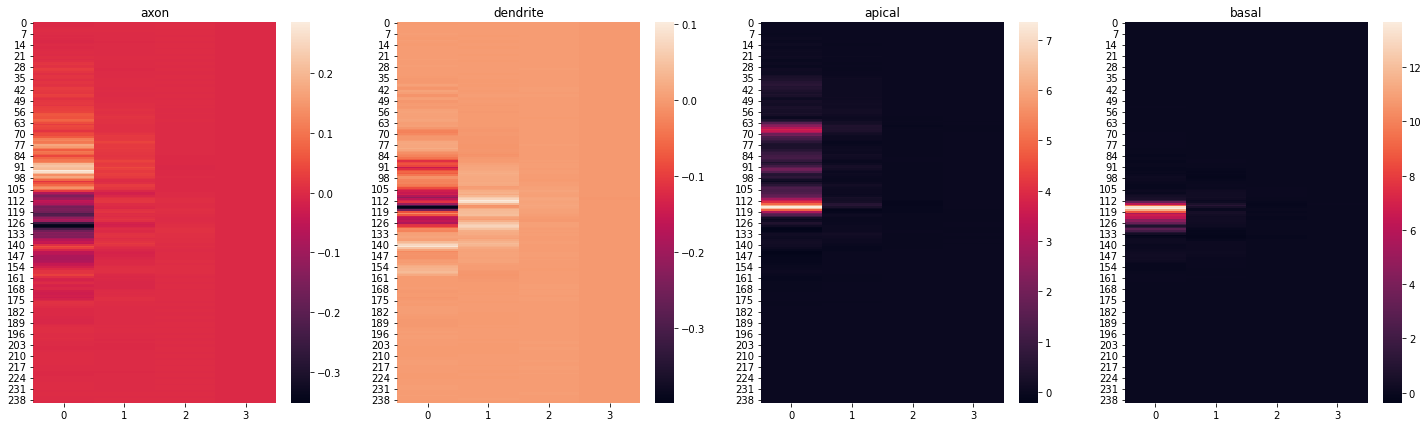

In [31]:
import seaborn as sns
out = T_ME
valid_ME = T_ME['ME_tot']
cell = np.random.randint(0,sum(valid_ME),1)[0]
print(cell)
fig, ax = plt.subplots(1,4, figsize=(25,7))
sns.heatmap(np.nan_to_num(out['XM'].squeeze())[valid_ME][cell,:,:,0], ax=ax[0], cbar=True) 
sns.heatmap(np.nan_to_num(out['XM'].squeeze())[valid_ME][cell,:,:,1], ax=ax[1], cbar=True)
sns.heatmap(np.nan_to_num(out['XM'].squeeze())[valid_ME][cell,:,:,2], ax=ax[2], cbar=True)
sns.heatmap(np.nan_to_num(out['XM'].squeeze())[valid_ME][cell,:,:,3], ax=ax[3], cbar=True)
ax[0].set_title("axon")
ax[1].set_title("dendrite")
ax[2].set_title("apical")
ax[3].set_title("basal")
plt.show()


fig, ax = plt.subplots(1,4, figsize=(25,7))
sns.heatmap(np.nan_to_num(out['XrM'].squeeze())[cell,:,:,0], ax=ax[0], cbar=True) 
sns.heatmap(np.nan_to_num(out['XrM'].squeeze())[cell,:,:,1], ax=ax[1], cbar=True)
sns.heatmap(np.nan_to_num(out['XrM'].squeeze())[cell,:,:,2], ax=ax[2], cbar=True)
sns.heatmap(np.nan_to_num(out['XrM'].squeeze())[cell,:,:,3], ax=ax[3], cbar=True)
ax[0].set_title("axon")
ax[1].set_title("dendrite")
ax[2].set_title("apical")
ax[3].set_title("basal")
plt.show()

### Cross modal reconstructions using valiation cells across folds
#### 1- T cross modal recon

In [32]:
#some functions
def get_val_cell_ind_of_selected_cells(exit_summary_pkl, select_mask):
    '''
    returns the val cells indices for an specific set of cells for example
    indices of validation cells of MET cells (cells that have all T, M and E).
    Or validation indices of the M cells (cells that have only M). 

    Args:
    ------
    exist_summary_pkl: the exist summary pkl file which has all the mask and and validation cell indices
    select_mask: mask of set of cells that we want the validation indices of those set 
    '''
    # 1- index of specific modality cells out of all cells
    select_cell_ind_tot = np.where(select_mask)[0]

    # 2- index of the train or val cells out of all cells
    val_cell_ind_tot = exit_summary_pkl['val']

    # 3- index of train or val cells of the specific modality out of all cells
    select_val_cell_ind_tot = np.array([i for i in select_cell_ind_tot if i in val_cell_ind_tot])

    # 4- index of train cells of the specific modality out of that modality cells
    select_val_cell_ind_modality = np.array([np.where(select_cell_ind_tot == i)[0][0] for i in select_val_cell_ind_tot])

    return select_val_cell_ind_modality


def restart_model_T_ME_version_0_0(model_class, stat_dict_pth, model_param_dict):
    '''
    Args:
    -----
    model_class: model class of T_ME version_0_0
    stat_dict_pth: path to the model saved stat_dict
    model_param_dict: model class parameters
    '''

    model = model_class(alpha_T=model_param_dict['alpha_T'],
    alpha_M=model_param_dict['alpha_M'],
    alpha_sd=model_param_dict['alpha_sd'],
    alpha_E=model_param_dict['alpha_E'],
    alpha_ME=model_param_dict['alpha_ME'],
    alpha_tune_ME=model_param_dict['alpha_tune_ME'],
    lambda_ME_T=model_param_dict['lambda_ME_T'],
    lambda_ME_M=model_param_dict['lambda_ME_M'],
    lambda_ME_E=model_param_dict['lambda_ME_E'],
    lambda_tune_ME_T=model_param_dict['lambda_tune_ME_T'],
    augment_decoders=model_param_dict['augment_decoders'],
    scale_factor=model_param_dict['scale_factor'],
    latent_dim=model_param_dict['latent_dim'], 
    E_features=model_param_dict['E_features'])
    
    model.load_state_dict(torch.load(stat_dict_pth)['state_dict'])
    return model

def get_model_input_tensors(exit_summary_pkl):
    device = torch.device('cpu')
    astensor_ = partial(astensor, device=device)
    XT = astensor_(exit_summary_pkl['XT'])
    XM = astensor_(exit_summary_pkl['XM'])
    Xsd = astensor_(exit_summary_pkl['Xsd'])
    XE = astensor_(exit_summary_pkl['XE'])
    return XT, XM, Xsd, XE

def get_exit_summary_pkl_filename(model_param_dict, n_fold):
    model_id = model_param_dict['model_id']
    alpha_T = model_param_dict['alpha_T']
    alpha_M = model_param_dict['alpha_M']
    alpha_sd = model_param_dict['alpha_sd']
    alpha_E = model_param_dict['alpha_E']
    alpha_ME = model_param_dict['alpha_ME']
    lambda_ME_T = model_param_dict['lambda_ME_T']
    lambda_tune_ME_T = model_param_dict['lambda_tune_ME_T']
    lambda_ME_M = model_param_dict['lambda_ME_M']
    lambda_ME_E = model_param_dict['lambda_ME_E']
    augment_decoders = model_param_dict['augment_decoders']
    E_noise = model_param_dict['E_noise']
    M_noise = model_param_dict['M_noise']
    scale_factor = model_param_dict['scale_factor']
    latent_dim = model_param_dict['latent_dim']
    n_epochs = model_param_dict['n_epochs']
    run_iter = model_param_dict['run_iter']
    filename = (model_id + f'_aT_{str(alpha_T)}_aM_{str(alpha_M)}_asd_{str(alpha_sd)}_aE_{str(alpha_E)}_aME_{str(alpha_ME)}_' +
              f'lambda_ME_T_{str(lambda_ME_T)}_lambda_tune_ME_T_{str(lambda_tune_ME_T)}_lambda_ME_M_{str(lambda_ME_M)}_'
              f'lambda_ME_E_{str(lambda_ME_E)}_aug_dec_{str(augment_decoders)}_' +
              f'Enoise_{str(E_noise)}_Mnoise_{str(M_noise)}_scale_{str(scale_factor)}_' +
              f'ld_{latent_dim:d}_ne_{n_epochs:d}_ri_{run_iter:d}_fold_{n_fold:d}').replace('.', '-')
    return "exit_summary_" + filename + ".pkl"


As I did not save all the cross validation reconstruction in the log files, I need to load the model to run it to get the cross validation values. For that I load all the models that I have in 10 folds then I run it for the valiadtion cells and get the cross modal reconstructions for T, E and M

In [33]:
device = torch.device('cpu')
astensor_ = partial(astensor, device=device) 

# Model parameters used
model_param_dict =  {"model_id": "corrected_val_cells_T_ME",
"alpha_T": 5.0, 
'alpha_M': 5.0, 
"alpha_E": 5.0, 
"alpha_sd": 5.0, 
"alpha_ME": 5.0,
"alpha_tune_ME": 0.5, 
"lambda_ME_T": 1.0,
"lambda_ME_M": 1.0, 
"lambda_ME_E": 1.0, 
"lambda_tune_ME_T": 0.75, 
"augment_decoders": 1, 
"scale_factor": 0.3,
"latent_dim":5, 
"E_features": 132, 
"n_epochs": 50000,
"run_iter": 0,
"M_noise": 0.0, 
"E_noise": 0.05} 

path_to_stat_dict_pt = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/" \
"cplAE_MET/data/results/triple_mode_version_0.0/" \
"corrected_val_cells_T_ME_aT_5.0_aE_5.0_aM_5.0_asd_5.0_aME_5.0_lmd_ME_T_1.0_lmd_ME_M_1.0_lmd_ME_E_1.0_lmd_tune_ME_T_0.75_aug_dec_1/"

XT_val = {}
XE_val = {}
XM_val = {}
Xsd_val = {}
XrT_from_zme = {}
XrT_from_ze = {}
XrT_from_zm = {}
XrE_from_zme = {}
XrE_from_zm = {}
XrE_from_zt = {}
XrM_from_zme = {}
XrM_from_ze = {}
XrM_from_zt = {}
Xrsd_from_zme = {}
Xrsd_from_ze = {}
Xrsd_from_zt = {}
met_val_cells = {}
met_val_cluster_labels = {}

for n_fold in range(10):

    # model saved
    model_stat_dict_pt = "best_model_"+str(n_fold)+".pt"

    # model output pkl
    pkl_file = get_exit_summary_pkl_filename(model_param_dict, n_fold)
    model_output_pkl  = ut.loadpkl(path_to_stat_dict_pt + pkl_file)

    # restart the model from the saved_stat_dict
    model = restart_model_T_ME_version_0_0(Model_T_ME, path_to_stat_dict_pt + model_stat_dict_pt, model_param_dict)
    
    # get index of val cells for the cells that have all M T and E available as we run cross validation for those only
    met_val_cells_fold = get_val_cell_ind_of_selected_cells(model_output_pkl, model_output_pkl['MET_tot'])

    # get cluster label of val cells
    met_val_cluster_labels[n_fold] = model_output_pkl['cluster_label'][model_output_pkl['MET_tot']][met_val_cells_fold]

    model.eval()
    with torch.no_grad():
        XT, XM, Xsd, XE = get_model_input_tensors(model_output_pkl)

        # get XT, XE, XM for the val cells of MET cells
        XT_val[n_fold] = XT[model_output_pkl['MET_tot']][met_val_cells_fold] 
        XE_val[n_fold] = XE[model_output_pkl['MET_tot']][met_val_cells_fold] 
        XM_val[n_fold] = XM[model_output_pkl['MET_tot']][met_val_cells_fold] 
        Xsd_val[n_fold] = Xsd[model_output_pkl['MET_tot']][met_val_cells_fold] 

        # cross modal recon for val cells of MET cells
        # cross recon T
        met_val_cells[n_fold] = met_val_cells_fold
        XrT_from_zme[n_fold] = model.dT(astensor_(model_output_pkl['zme'][model_output_pkl['MET_ME']][met_val_cells_fold]))
        XrT_from_ze[n_fold] = model.dT(astensor_(model_output_pkl['ze'][model_output_pkl['MET_E']][met_val_cells_fold]))
        XrT_from_zm[n_fold] = model.dT(astensor_(model_output_pkl['zm'][model_output_pkl['MET_M']][met_val_cells_fold]))
        
        # cross recon E
        XrE_inter_from_zme = model.dE_specific(astensor_(model_output_pkl['zme'][model_output_pkl['MET_ME']][met_val_cells_fold]))
        XrE_from_zme[n_fold] = model.dE_shared(XrE_inter_from_zme)
        XrE_inter_from_zm = model.dE_specific(astensor_(model_output_pkl['zm'][model_output_pkl['MET_M']][met_val_cells_fold]))
        XrE_from_zm[n_fold] = model.dE_shared(XrE_inter_from_zm)
        XrE_inter_from_zt = model.dE_specific(astensor_(model_output_pkl['zt'][model_output_pkl['MET_T']][met_val_cells_fold]))
        XrE_from_zt[n_fold] = model.dE_shared(XrE_inter_from_zt)

        # cross recon M
        # We need to run the encoder once becasue we need pool_ind1 and pool_ind2 in the decoder part
        _, _, pool_ind1, pool_ind2, _ = model.eM_shared(XM[model_output_pkl['MET_tot']][met_val_cells_fold], Xsd[model_output_pkl['MET_tot']][met_val_cells_fold])
        XrM_inter_from_zme = model.dM_specific(astensor_(model_output_pkl['zme'][model_output_pkl['MET_ME']][met_val_cells_fold]))
        XrM_from_zme[n_fold], Xrsd_from_zme[n_fold] = model.dM_shared(XrM_inter_from_zme, pool_ind1, pool_ind2)
        XrM_inter_from_ze = model.dM_specific(astensor_(model_output_pkl['zm'][model_output_pkl['MET_M']][met_val_cells_fold]))
        XrM_from_ze[n_fold], Xrsd_from_ze[n_fold] = model.dM_shared(XrM_inter_from_ze, pool_ind1, pool_ind2)
        XrM_inter_from_zt = model.dM_specific(astensor_(model_output_pkl['zt'][model_output_pkl['MET_T']][met_val_cells_fold]))
        XrM_from_zt[n_fold], Xrsd_from_zt[n_fold] = model.dM_shared(XrM_inter_from_zt, pool_ind1, pool_ind2)

In [34]:
# I have saved gene ids in the model output but not E_feature_names, Rohan please do this, sorry i did not have time
gene_ids = model_output_pkl['gene_ids']
E_features = pd.read_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/proc/E_data_30Mar22.csv").drop(columns=['specimen_id']).columns.to_list()

select_genes = ["Vip", "Npy", "Sst", "Penk", "Cck", "Crh", "Tac1", "Pdyn", "Pnoc", "Adcyap1", "Grp", "Nts", "Rln1", "Vipr1", "Npy1r", "Npy2r", "Npy5r", "Sstr1", "Sstr2", "Sstr4", "Oprd1", "Oprm1", "Cckbr", "Crhr1", "Crhr2",
"Tacr1", "Trhr", "Nmbr", "Ntsr1", "Rxfp1", "Rxfp3", "Slc30a3", "Cux2", "Rorb", "Deptor", "Rspo1", "Hsd11b1", "Pvalb", "Fam84b", "Foxp2", "Slc17a8", "Trhr", "Tshz2", "Nxph4", "Gpr139", "Rprm", "Crym"]

select_E_features = E_features[-24:]

In [35]:
# Create dataframes, group by cell type and then average over all the validation cells to get the reconstruction of a modality and compare it with ground truth

def combine_all_fold_df(df_input, columns, cluster_labels):
    '''
    Takes data from all fold and make a data frame and combine it with the cluster labels and so on for T and E
    '''
    all_val_df = pd.DataFrame()
    for n_fold in range(10):
        df = pd.DataFrame(tonumpy(df_input[n_fold]), columns=columns)
        df['cluster_label'] = cluster_labels[n_fold]
        all_val_df = pd.concat([all_val_df, df])
    return all_val_df

In [36]:
# Combine data across folds, subset , groupby cluster label and get the mean
gene_ids = [mystr.rstrip() for mystr in model_output_pkl['gene_ids']]
all_XT_val = combine_all_fold_df(XT_val, gene_ids, met_val_cluster_labels).groupby('cluster_label').mean()[select_genes]
all_XrT_from_zme = combine_all_fold_df(XrT_from_zme, gene_ids, met_val_cluster_labels).groupby('cluster_label').mean()[select_genes]
all_XrT_from_zm = combine_all_fold_df(XrT_from_ze, gene_ids, met_val_cluster_labels).groupby('cluster_label').mean()[select_genes]
all_XrT_from_ze = combine_all_fold_df(XrT_from_zm, gene_ids, met_val_cluster_labels).groupby('cluster_label').mean()[select_genes]

all_XE_val = combine_all_fold_df(XE_val, E_features, met_val_cluster_labels).groupby('cluster_label').mean()[select_E_features]
all_XrE_from_zt = combine_all_fold_df(XrE_from_zt, E_features, met_val_cluster_labels).groupby('cluster_label').mean()[select_E_features]
all_XrE_from_zme = combine_all_fold_df(XrE_from_zme, E_features, met_val_cluster_labels).groupby('cluster_label').mean()[select_E_features]
all_XrE_from_zm = combine_all_fold_df(XrE_from_zm, E_features, met_val_cluster_labels).groupby('cluster_label').mean()[select_E_features]

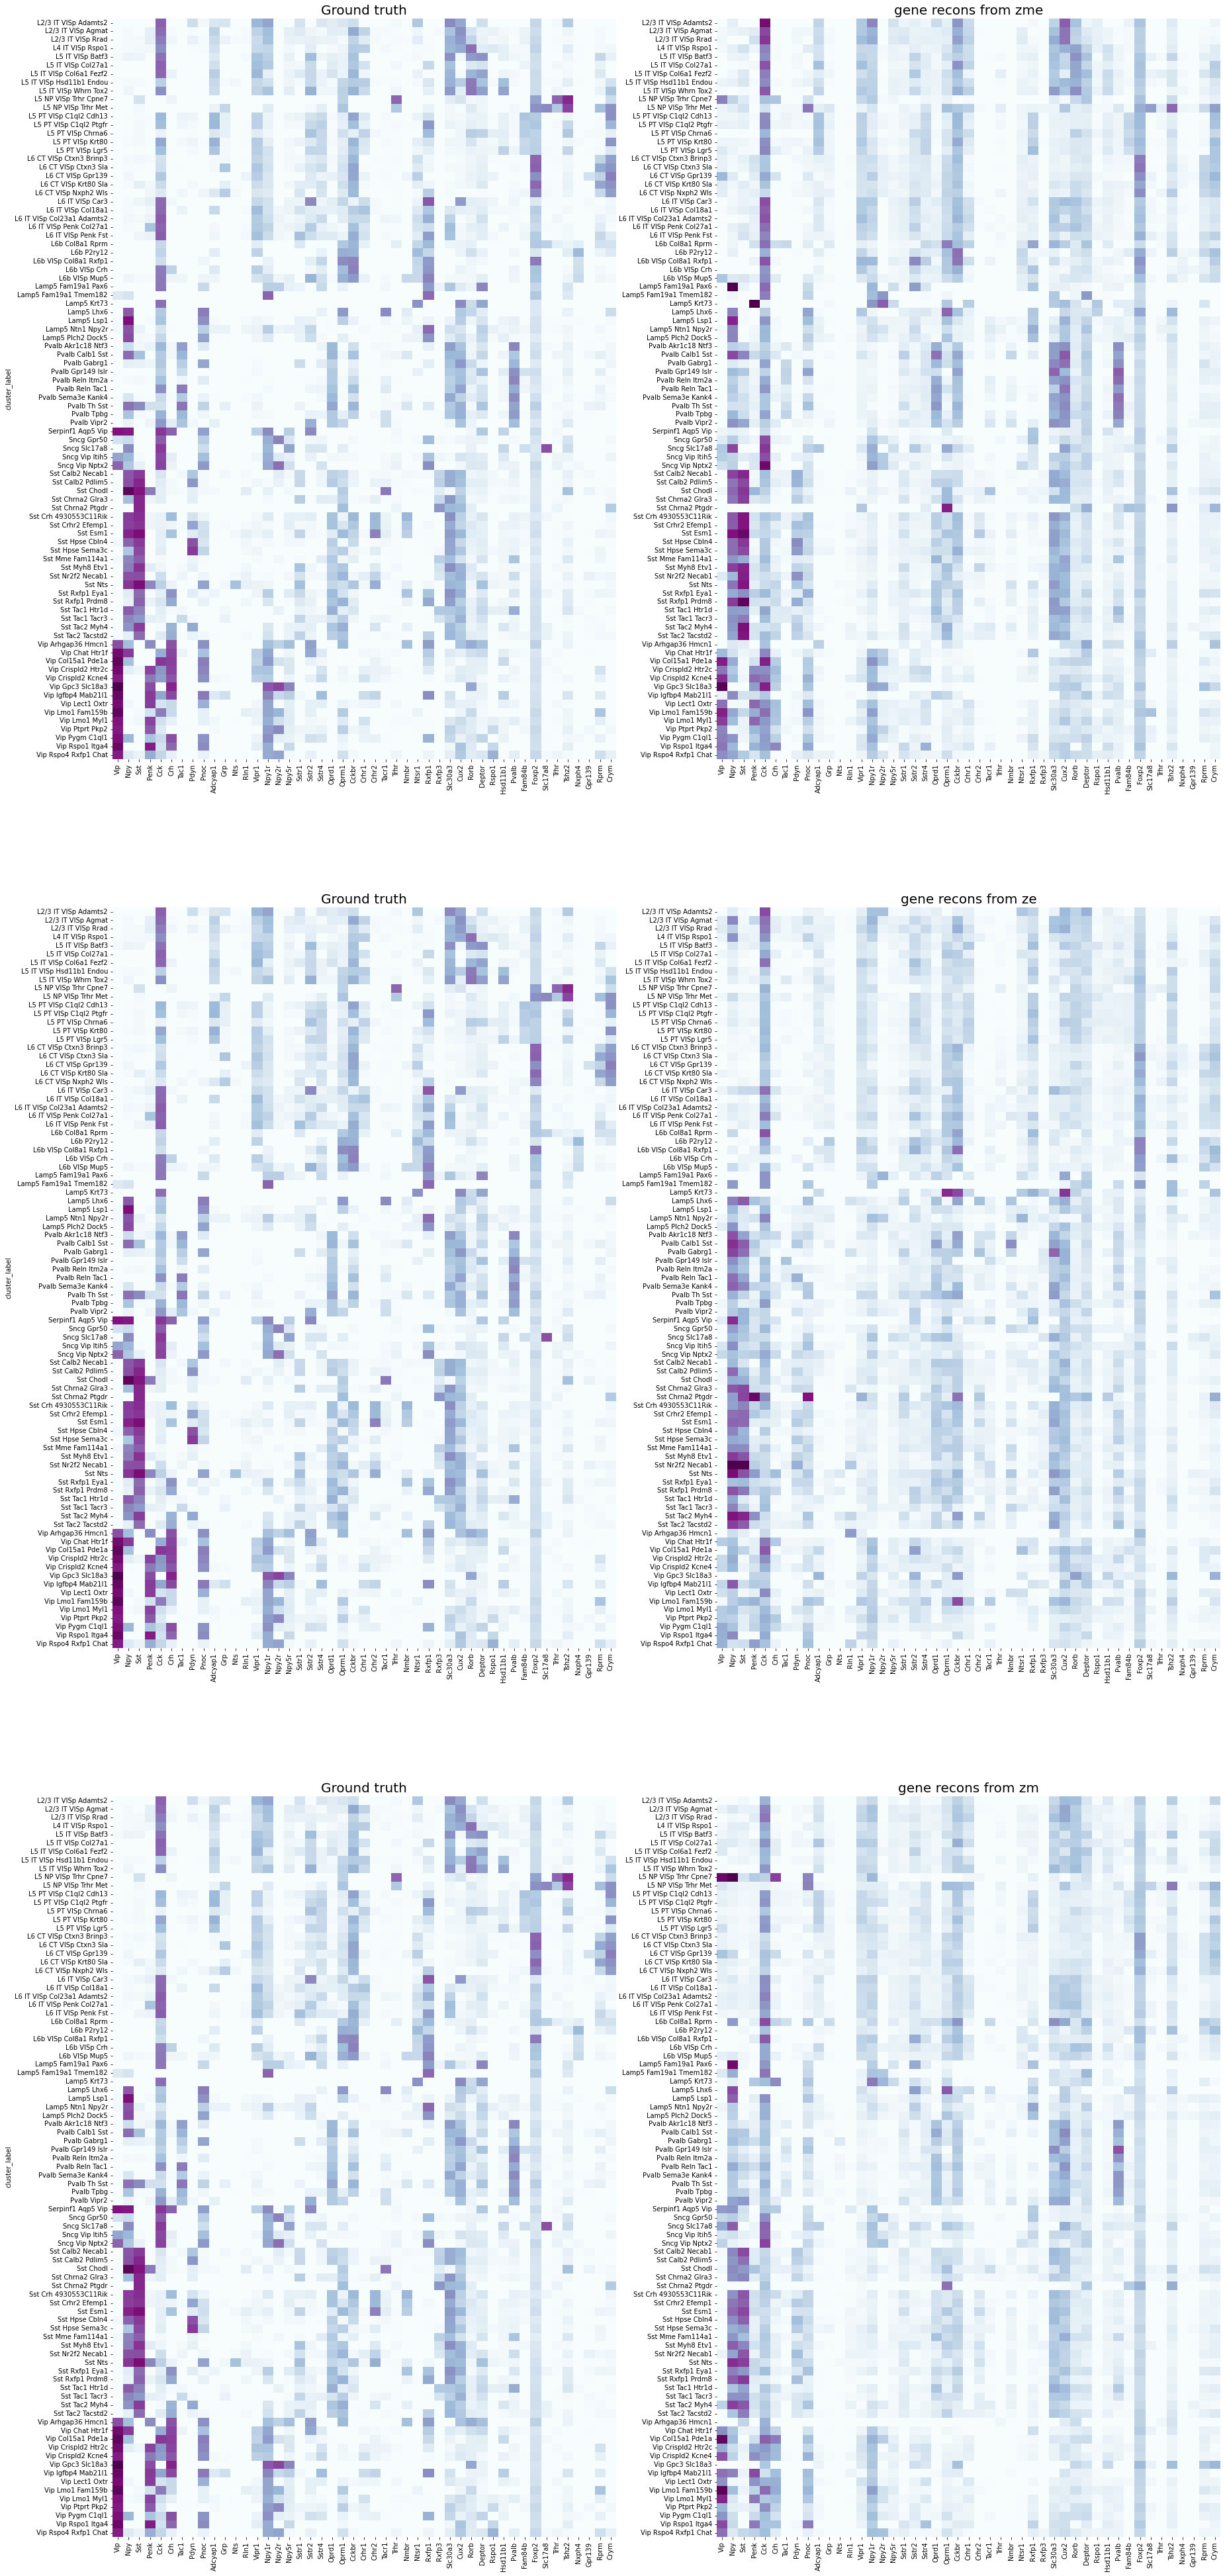

In [37]:
import seaborn as sns
fig, ax = plt.subplots(3,2, figsize=(30,70))
sns.heatmap(all_XT_val, ax=ax[0][0], cbar=False, cmap="BuPu")
sns.heatmap(all_XrT_from_zme, ax=ax[0][1], cbar=False, cmap="BuPu") 
sns.heatmap(all_XT_val, ax=ax[1][0], cbar=False, cmap="BuPu") 
sns.heatmap(all_XrT_from_ze, ax=ax[1][1], cbar=False, cmap="BuPu") 
sns.heatmap(all_XT_val, ax=ax[2][0], cbar=False, cmap="BuPu") 
sns.heatmap(all_XrT_from_zm, ax=ax[2][1], cbar=False, cmap="BuPu") 

ax[0][0].set_title("Ground truth", size=20)
ax[0][1].set_title("gene recons from zme", size=20)
ax[1][0].set_title("Ground truth", size=20)
ax[1][1].set_title("gene recons from ze", size=20)
ax[2][0].set_title("Ground truth", size=20)
ax[2][1].set_title("gene recons from zm", size=20)

ax[0][1].set_ylabel("")
ax[1][1].set_ylabel("")
ax[2][1].set_ylabel("")

plt.show()

In [38]:
fig.savefig("/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/triple_mode_version_0.0/T_cross_modal_recon.pdf", dpi=350)

### 2- E cross modal recon

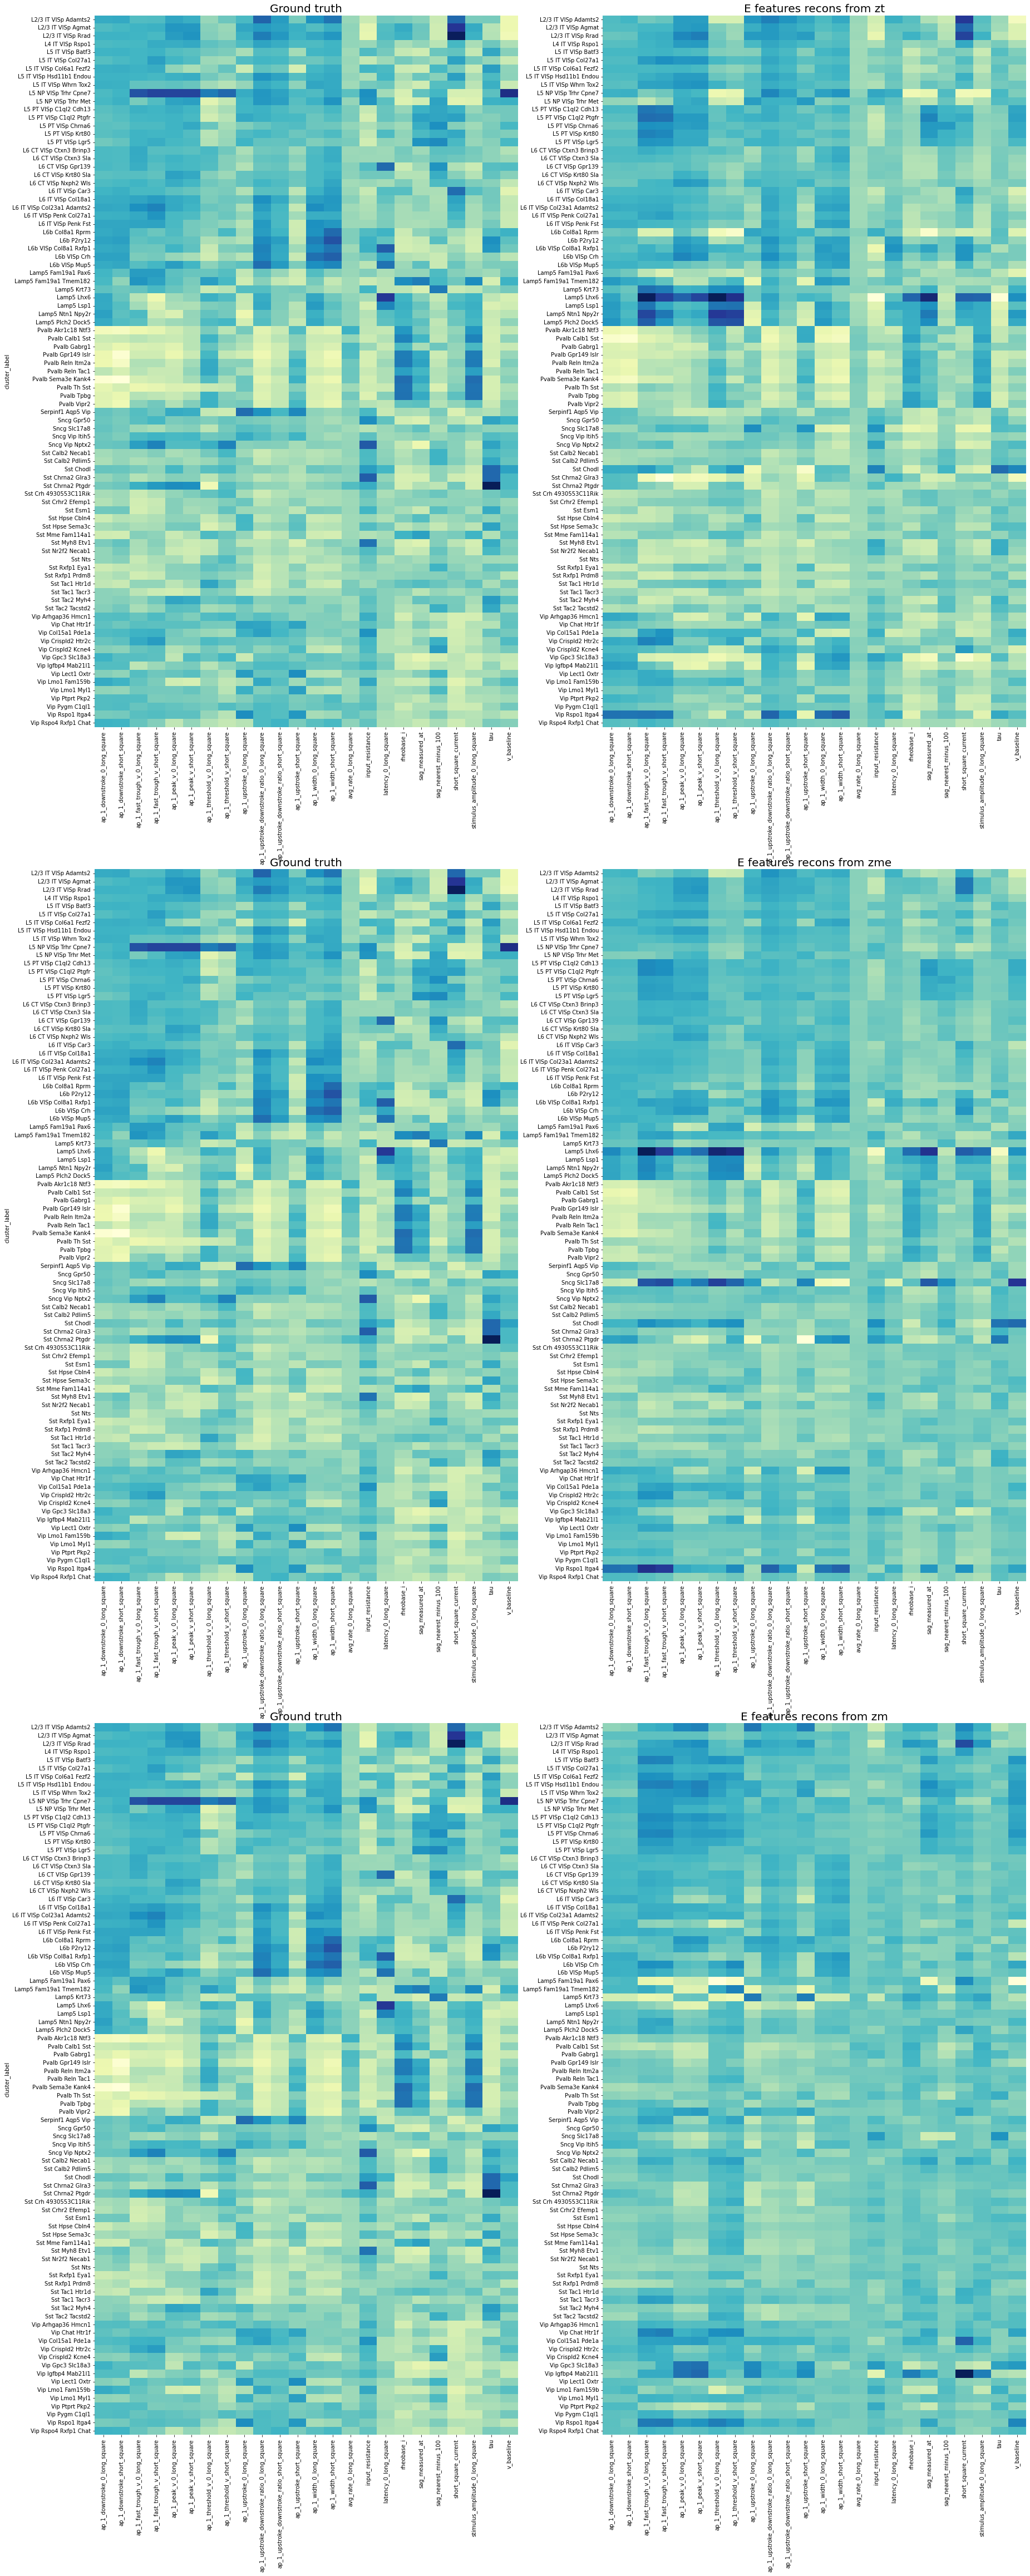

In [39]:
fig, ax = plt.subplots(3,2, figsize=(30,80))
sns.heatmap(all_XE_val, ax=ax[0][0], cbar=False, cmap="YlGnBu")
sns.heatmap(all_XrE_from_zt, ax=ax[0][1], cbar=False, cmap="YlGnBu") 
sns.heatmap(all_XE_val, ax=ax[1][0], cbar=False, cmap="YlGnBu") 
sns.heatmap(all_XrE_from_zme, ax=ax[1][1], cbar=False, cmap="YlGnBu") 
sns.heatmap(all_XE_val, ax=ax[2][0], cbar=False, cmap="YlGnBu") 
sns.heatmap(all_XrE_from_zm, ax=ax[2][1], cbar=False, cmap="YlGnBu") 

ax[0][0].set_title("Ground truth", size=20)
ax[0][1].set_title("E features recons from zt", size=20)
ax[1][0].set_title("Ground truth", size=20)
ax[1][1].set_title("E features recons from zme", size=20)
ax[2][0].set_title("Ground truth", size=20)
ax[2][1].set_title("E features recons from zm", size=20)

ax[0][1].set_ylabel("")
ax[1][1].set_ylabel("")
ax[2][1].set_ylabel("")

plt.show()

In [40]:
fig.savefig("/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/results/triple_mode_version_0.0/E_cross_modal_recon.pdf", dpi=350)

### M cross modal recon

66


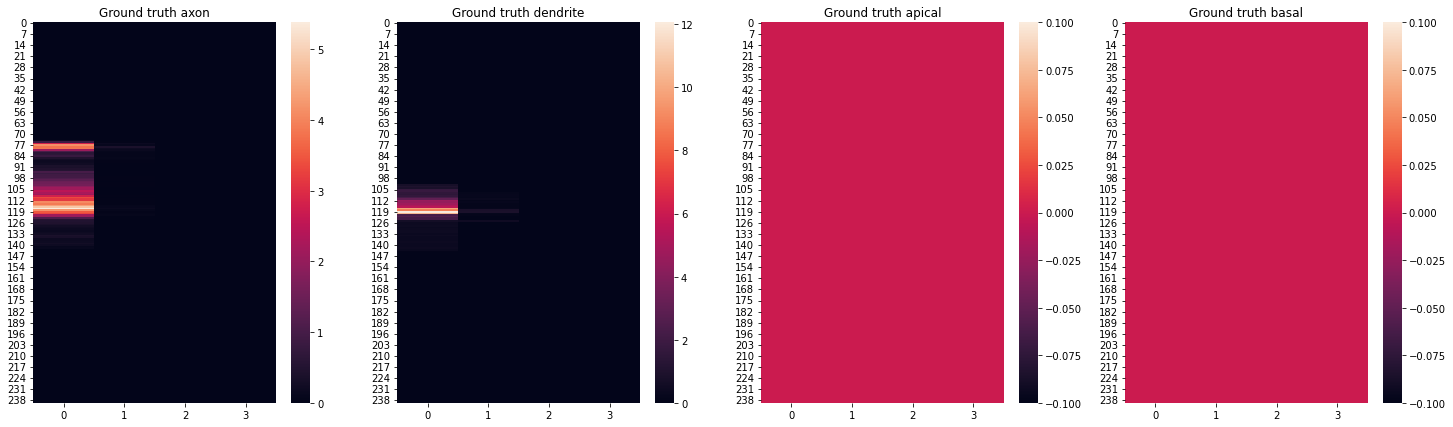

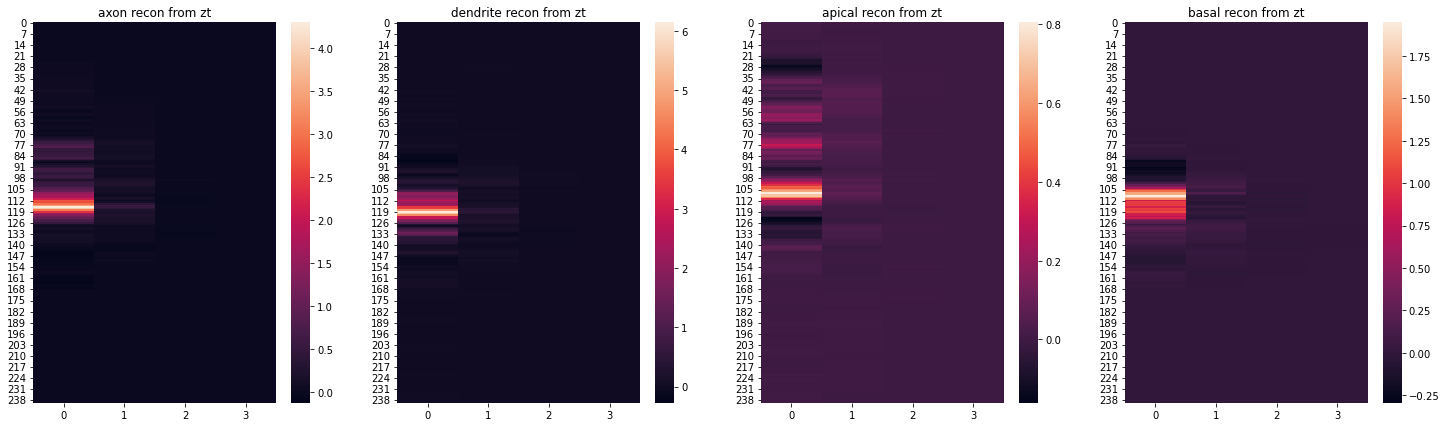

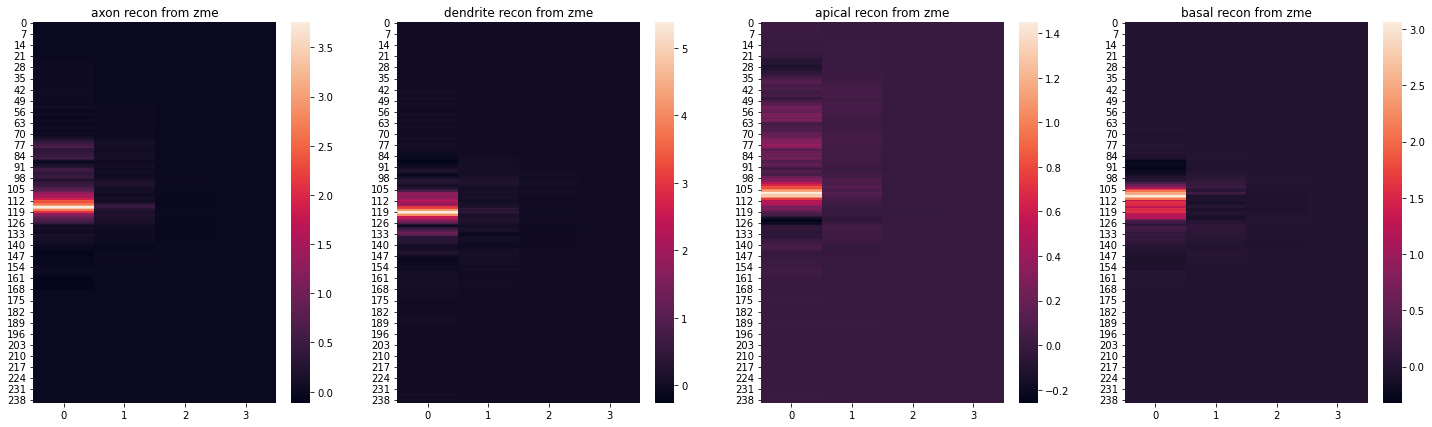

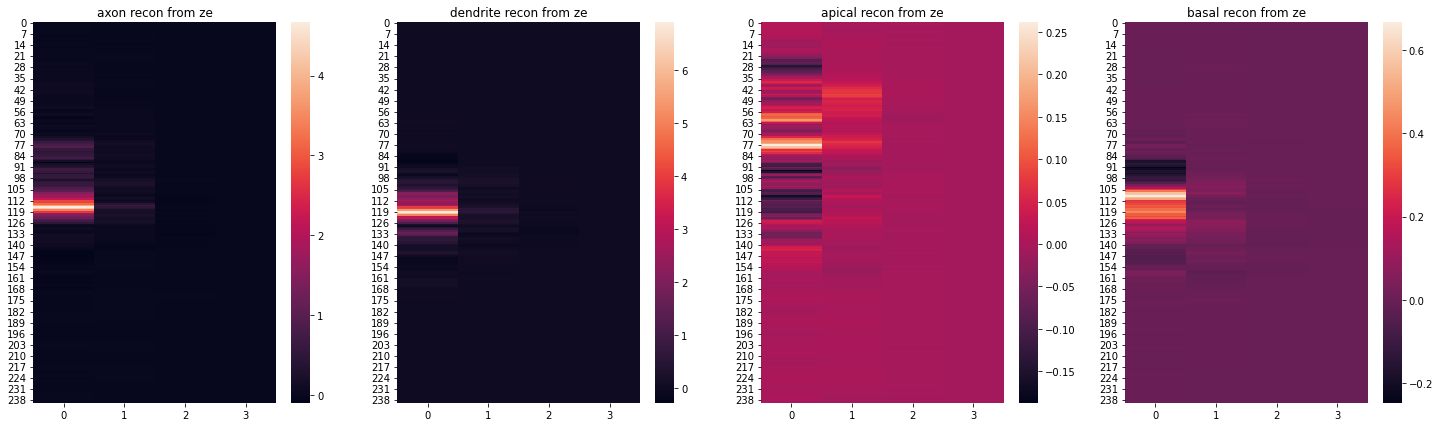

In [41]:
import seaborn as sns
out = model_output_pkl
MET_val_cells = met_val_cells[9]

cell = np.random.randint(0,len(MET_val_cells),1)[0]
print(cell)
fig, ax = plt.subplots(1,4, figsize=(25,7))
sns.heatmap(out['XM'].squeeze()[model_output_pkl['MET_tot']][MET_val_cells][cell,:,:,0], ax=ax[0], cbar=True) 
sns.heatmap(out['XM'].squeeze()[model_output_pkl['MET_tot']][MET_val_cells][cell,:,:,1], ax=ax[1], cbar=True)
sns.heatmap(out['XM'].squeeze()[model_output_pkl['MET_tot']][MET_val_cells][cell,:,:,2], ax=ax[2], cbar=True)
sns.heatmap(out['XM'].squeeze()[model_output_pkl['MET_tot']][MET_val_cells][cell,:,:,3], ax=ax[3], cbar=True)
ax[0].set_title("Ground truth axon")
ax[1].set_title("Ground truth dendrite")
ax[2].set_title("Ground truth apical")
ax[3].set_title("Ground truth basal")
plt.show()


fig, ax = plt.subplots(1,4, figsize=(25,7))
sns.heatmap(XrM_from_zt[n_fold].squeeze()[cell,:,:,0], ax=ax[0], cbar=True) 
sns.heatmap(XrM_from_zt[n_fold].squeeze()[cell,:,:,1], ax=ax[1], cbar=True)
sns.heatmap(XrM_from_zt[n_fold].squeeze()[cell,:,:,2], ax=ax[2], cbar=True)
sns.heatmap(XrM_from_zt[n_fold].squeeze()[cell,:,:,3], ax=ax[3], cbar=True)
ax[0].set_title("axon recon from zt")
ax[1].set_title("dendrite recon from zt")
ax[2].set_title("apical recon from zt")
ax[3].set_title("basal recon from zt")
plt.show()

fig, ax = plt.subplots(1,4, figsize=(25,7))
sns.heatmap(XrM_from_zme[n_fold].squeeze()[cell,:,:,0], ax=ax[0], cbar=True) 
sns.heatmap(XrM_from_zme[n_fold].squeeze()[cell,:,:,1], ax=ax[1], cbar=True)
sns.heatmap(XrM_from_zme[n_fold].squeeze()[cell,:,:,2], ax=ax[2], cbar=True)
sns.heatmap(XrM_from_zme[n_fold].squeeze()[cell,:,:,3], ax=ax[3], cbar=True)
ax[0].set_title("axon recon from zme")
ax[1].set_title("dendrite recon from zme")
ax[2].set_title("apical recon from zme")
ax[3].set_title("basal recon from zme")
plt.show()

fig, ax = plt.subplots(1,4, figsize=(25,7))
sns.heatmap(XrM_from_ze[n_fold].squeeze()[cell,:,:,0], ax=ax[0], cbar=True) 
sns.heatmap(XrM_from_ze[n_fold].squeeze()[cell,:,:,1], ax=ax[1], cbar=True)
sns.heatmap(XrM_from_ze[n_fold].squeeze()[cell,:,:,2], ax=ax[2], cbar=True)
sns.heatmap(XrM_from_ze[n_fold].squeeze()[cell,:,:,3], ax=ax[3], cbar=True)
ax[0].set_title("axon recon from ze")
ax[1].set_title("dendrite recon from ze")
ax[2].set_title("apical recon from ze")
ax[3].set_title("basal recon from ze")
plt.show()